## Overview: Multiclass classification
- A classification task with more than two classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multiclass classification assumes each sample is assigned to one and only one label (mutually exclusive).
- Common examples include image classification (cat, dog, human, etc.) or handwritten digit recognition (classifying an image into a digit from 0 to 9).
- In machine learning, multiclass (multinomial) classification is the problem of classifying instances into one of three or more classes (two classes is binary classification).
- Multiclass classification should not be confused with multi-label classification, where multiple labels can be predicted for each instance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from sklearn.datasets import make_blobs

In [2]:
# some helper function below to plot data
def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, 
                legend=False, size=50, m='o', equal_xy = False):
    """ Plot multiclass data. Note, if equal_xy is True, setting ylim on the plot may not work """
    
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        # Use numeric class labels with a colormap to avoid warnings about vmin/vmax being ignored
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, cmap=map, vmin=0, vmax=classes-1,
                    s=size, label=label)
    if legend: ax.legend()
    if equal_xy: ax.axis("equal")

def plt_mc(X_train,y_train,classes, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax, X_train,y_train,classes, map=plt.cm.Paired, legend=True, size=50, equal_xy = False)
    ax.set_title("Multiclass Data")
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    plt.show()
    

## 1. Prepare and visualize our data
We will use Scikit-Learn `make_blobs` function to make a training data set with 4 categories as shown in the plot below.

In [3]:
# make 4-class dataset for classification
classes = 4
m = 500
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
std = 1.0
X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std,random_state=30)

# add more noise to the data
np.random.seed(42)
X += np.random.normal(0, 0.75, X.shape)


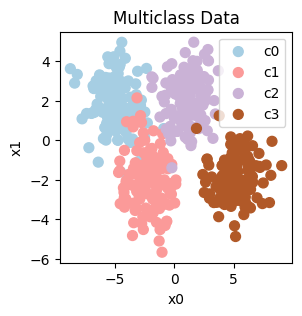

In [4]:
plt_mc(X,y,classes, centers, std=std)

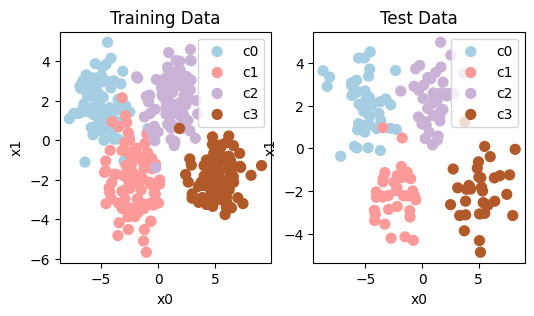

In [5]:
# split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# plot side by side subplots on training and test data
fig,ax = plt.subplots(1,2,figsize=(6,3))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
plt_mc_data(ax[0], X_train,y_train,classes, map=plt.cm.Paired, legend=True, size=50, equal_xy = False)
ax[0].set_title("Training Data")
ax[0].set_xlabel("x0")
ax[0].set_ylabel("x1")
plt_mc_data(ax[1], X_test,y_test,classes, map=plt.cm.Paired, legend=True, size=50, equal_xy = False)
ax[1].set_title("Test Data")
ax[1].set_xlabel("x0")
ax[1].set_ylabel("x1")
plt.show()


##  Softmax (Multinominal Logistic Regression)

###  Softmax Function

In softmax regression, N outputs are generated and one output is selected as the predicted category. In this case a vector $\mathbf{z}$ is generated by a linear function which is applied to a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will add to 1, so that they can be interpreted as probabilities. The larger inputs  will correspond to larger output probabilities.
<center>  <img  src="./images/C2_W2_SoftmaxReg_NN.png" width="600" />  

The softmax function can be written:

$$a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1}$$


Which shows the output is a vector of probabilities. The first entry is the probability the input is the first category given the input $\mathbf{x}$ and parameters $\mathbf{w}$ and $\mathbf{b}$.  
Let's create a NumPy implementation:



In [6]:
def my_softmax(z):
    ez = np.exp(z)              #element-wise exponenial
    sm = ez/np.sum(ez)
    return(sm)

###  Softmax Cost
<center> <img  src="./images/C2_W2_SoftMaxCost.png" width="400" />    <center/>

The loss function associated with Softmax, the cross-entropy loss, is:
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{if $y=N$}
  \end{cases} \tag{3}
\end{equation}

Where y is the target category for this example and $\mathbf{a}$ is the output of a softmax function. In particular, the values in $\mathbf{a}$ are probabilities that sum to one.
>**Recall:** In this course, Loss is for one example while Cost covers all examples. 
 
 
Note in (3) above, only the line that corresponds to the target contributes to the loss, other lines are zero. To write the cost equation we need an 'indicator function' that will be 1 when the index matches the target and zero otherwise. 
    $$\mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{if $y==n$}.\\
    0, & \text{otherwise}.
  \end{cases}$$
Now the cost is:
\begin{align}
J(\mathbf{w},b) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

Where $m$ is the number of examples, $N$ is the number of outputs. This is the average of all the losses.



###  Multinominal Logistic Regression

Let's build a model

In [7]:
from sklearn.linear_model import LogisticRegression


# Train multinomial logistic regression classifier
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

# Get the predicted probabilities for each class
y_pred_probabilities = logreg_classifier.predict_proba(X_test)
y_pred_probabilities[:5]

array([[1.27216993e-09, 6.58037640e-05, 9.03350355e-03, 9.90900691e-01],
       [1.86756635e-02, 9.81322723e-01, 1.54807674e-06, 6.57915210e-08],
       [4.31359789e-04, 4.36819179e-02, 9.11318272e-01, 4.45684498e-02],
       [9.90363155e-01, 9.55004145e-03, 8.68035555e-05, 5.51400901e-11],
       [1.78749241e-01, 6.36063663e-01, 1.85022645e-01, 1.64450808e-04]])

In [8]:
y_pred = logreg_classifier.predict(X_test)
y_pred

array([3, 1, 2, 0, 1, 3, 0, 3, 2, 0, 3, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 3,
       0, 2, 3, 2, 2, 3, 1, 0, 3, 0, 0, 0, 2, 2, 1, 3, 1, 2, 2, 3, 0, 3,
       2, 2, 1, 2, 1, 0, 0, 3, 1, 1, 2, 0, 2, 1, 3, 2, 0, 1, 0, 3, 2, 3,
       2, 1, 2, 1, 1, 2, 1, 0, 1, 3, 1, 2, 1, 2, 0, 2, 0, 0, 1, 2, 1, 1,
       0, 1, 1, 0, 3, 1, 1, 2, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 1, 0, 1, 1,
       0, 2, 1, 0, 3, 3, 2, 3, 2, 0, 2, 2, 3, 3, 2, 3, 1, 2, 0, 2, 2, 2,
       2, 3, 0, 3, 3, 3, 3, 1, 0, 0, 3, 3, 1, 3, 0, 0, 1, 2])

In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix
pd.DataFrame(confusion_matrix(y_test,y_pred))
print(round(accuracy_score(y_test, y_pred), 2))

0.97


In [10]:
confusion_matrix(y_test,y_pred)

array([[40,  2,  1,  0],
       [ 1, 34,  0,  0],
       [ 0,  0, 39,  0],
       [ 0,  0,  1, 32]])

###  Softmax Classifier in Neural Nets


#### MLPClassifier from Sklearn


`MLPClassifier` in scikit-learn is a multi-layer perceptron (MLP) classifier, which is a type of artificial neural network. It can be used for multi-class classification tasks by learning a mapping from input features to output class labels.

In [11]:
# build a neural network classifier on the data
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp_classifier.fit(X_train, y_train)

# make prediction on the test data
y_pred = mlp_classifier.predict(X_test)

# output the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# output the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

Confusion Matrix:
[[42  0  1  0]
 [ 1 34  0  0]
 [ 0  0 39  0]
 [ 0  0  1 32]]
Accuracy: 0.98


In [12]:
y_pred_prob = mlp_classifier.predict_proba(X_test)
print("Prediction Probabilities:", y_pred_prob[:5])

Prediction Probabilities: [[9.24398681e-05 1.02596901e-04 1.70025537e-03 9.98104708e-01]
 [5.37720633e-03 9.94598087e-01 6.80165563e-06 1.79046148e-05]
 [4.06557707e-03 7.28238605e-03 9.46717295e-01 4.19347418e-02]
 [9.88473178e-01 1.14975639e-02 1.00171446e-05 1.92408899e-05]
 [2.68934488e-01 6.55079567e-01 6.65264894e-02 9.45945541e-03]]


In [13]:
# add all probabities for each instance 
y_pred_prob.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Noticeably, the sum of probabilities for each instance totals to 1, a characteristic indicative of the use of softmax for multi-class classification. Now, let's take a step further and explicitly construct a neural network classifier, specifying the output layer with softmax activation

####  Keras

In [14]:
# Set PyTorch as the backend for Keras before importing Keras
import os
os.environ["KERAS_BACKEND"] = "torch"

# Now import Keras (it will use PyTorch as backend)
import keras
from keras.models import Sequential
from keras.layers import Dense

# build a neural network classifier on the data
keras_classifier = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'softmax')    # < softmax activation here
    ]
)

keras_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(0.001),
)

keras_classifier.fit(
    X_train, y_train,
    epochs=10
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.2141
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9960
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8537
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7530
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6712
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6015
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5440
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4889
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4407
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3990


Because the softmax is integrated into the output layer, the output is a vector of probabilities.

In [15]:
# show first few predicted probability vectors from the Keras (torch-backend) model
p_nonpreferred = keras_classifier.predict(X_test)
print(p_nonpreferred[:2])
print("largest value", np.max(p_nonpreferred), "smallest value", np.min(p_nonpreferred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[7.7750639e-04 3.9294202e-02 5.2393205e-02 9.0753508e-01]
 [8.4925599e-02 6.4651793e-01 6.1048411e-02 2.0750807e-01]]
largest value 0.99341726 smallest value 1.985526e-06


In [16]:
# output accuracy and confusion matrix
y_pred = np.argmax(p_nonpreferred, axis=1)
print(round(accuracy_score(y_test, y_pred), 2))
print(confusion_matrix(y_test, y_pred))


0.97
[[43  0  0  0]
 [ 2 33  0  0]
 [ 1  0 38  0]
 [ 0  0  1 32]]


##  Accuracy, precision, recall, and f1 score for multiclass classification

In multiclass classification, accuracy is calculated in the same way as in binary classification, but precision, recall, and F1-score are calculated for each class individually.

Please refer to the following figure for the caculation

<img src="https://www.sefidian.com/wp-content/uploads/2023/04/image-40.png" alt="Image" style="width:450px;"/>

In [17]:
## output the performance metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        43
           1       1.00      0.94      0.97        35
           2       0.97      0.97      0.97        39
           3       1.00      0.97      0.98        33

    accuracy                           0.97       150
   macro avg       0.98      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In multiclass classification, these metrics are calculated separately for each class, and then typically aggregated using some form of averaging (e.g., micro-average, macro-average, weighted average) to obtain overall performance measures. This allows us to evaluate the classifier's performance on each class individually as well as on the entire dataset. 

In [18]:
## output the precision, recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: {:.2f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred, average='macro')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred, average='macro')))


Precision: 0.98
Recall: 0.97
F1 Score: 0.97


In multiclass classification, macro-average and weighted average are two commonly used methods for aggregating performance metrics (such as precision, recall, and F1-score) across multiple classes to obtain overall performance measures.

Below is an explanation of each:


### Macro-averaging
**verage the precision and recall across all classes** to get the final macro-averaged precision and recall scores.

<img src="https://assets-global.website-files.com/6266b596eef18c1931f938f9/644afed8b72fe836c6eae060_class_guide_multi_abc13.png" alt="Image" style="width:450px;"/>


In [19]:
## output the precision, recall and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: {:.2f}".format(precision_score(y_test, y_pred, average='weighted')))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred, average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred, average='weighted')))

Precision: 0.97
Recall: 0.97
F1 Score: 0.97


### Weighted averaging
This approach takes into account the balance of classes. You weigh each class based on its representation in the dataset. Then, you compute precision and recall as a weighted average of the precision and recall in individual classes.

Simply put, it would work like macro-averaging, but instead of dividing precision and recall by the number of classes, you give each class a fair representation based on the proportion it takes in the dataset. 

This approach is useful if you have an imbalanced dataset but want to assign larger importance to classes with more examples. 

## Congratulations!
In this lab you 
* Extended the binary classification to multiclass classification
* Explored different ML classifiers for multiclass classification
* Got to know softmax function, which is widely used in neural networks
* Explored the distinctions in performance metrics between multiclass and binary classification.
